# Final Report

1. [Executive Summary](#1.-Executive-Summary)

2. [Aim and Background](#2.-Aim-and-Background)  
    2.1 [Problem](#2.1-Problem)  
    2.2 [Aim](#2.2-Aim)  
    2.3 [Background](#2.3-Background)  
        
3. [Methods](#3.-Methods)  
   3.1 [Data Collection](#3.1.-Data-Collection)  
   3.2 [Data Preprocessing](#3.2.-Data-Preprocessing)  
   3.3 [Models](#3.3.-Models)  
   3.4 [Evaluation Strategies](#3.4.-Evaluation-Strategies)  
   
4. [Results](#4.-Results)  
   4.1 [Part A - Evaluation](#4.1.-Part-A)  
   4.2 [Part B - Product Results](#4.2-Part-B)  
   
5. [Discussion and Conclusion](#5.-Discussion-and-Conclusion)  
  5.1 [Issues Addressed](#5.1.-Issues-Addressed)  
  5.2 [Future Work](#5.2.-Future-Work)  
  5.3 [Conclusion](#5.3.-Conclusion)

6. [Student Contributions](#6.-Student-Contribution)  
  
7. [References](#7.-References)  

8. [Appendix](#8.-Appendix)

Operating System: Linux  
GPU: None  
Python Version: 3.10  
Python Packages: See requirements.txt  

GitHub Repo: [https://github.com/mattyhempstead/brain4](https://github.com/mattyhempstead/brain4)

Usage: Install `requirements.txt` and run notebook cells sequentially (you may wish to skip hyperparameter tuning).

## 1. Executive Summary

Patients suffering from motor-neuron diseases experience difficulty communicating through traditional input devices such as keyboards. However, in most cases, patients retain functionality of the eyes, thus opening a potential channel for communication. In the present work, an innovative virtual keyboard using eye movements was developed for patients with limited motor function and speech. Using an electrooculography (EOG) based human-computer interface, eye movements were encoded to operate an intuitive binary tree keyboard. By enabling them to type and communicate by digital means, our solution has potential to significantly improve a patients quality of life.

#### Figure 1: Data-flow Diagram
The final implementation consists of four distinct stages: data acquisition, processing, classification and user interface.
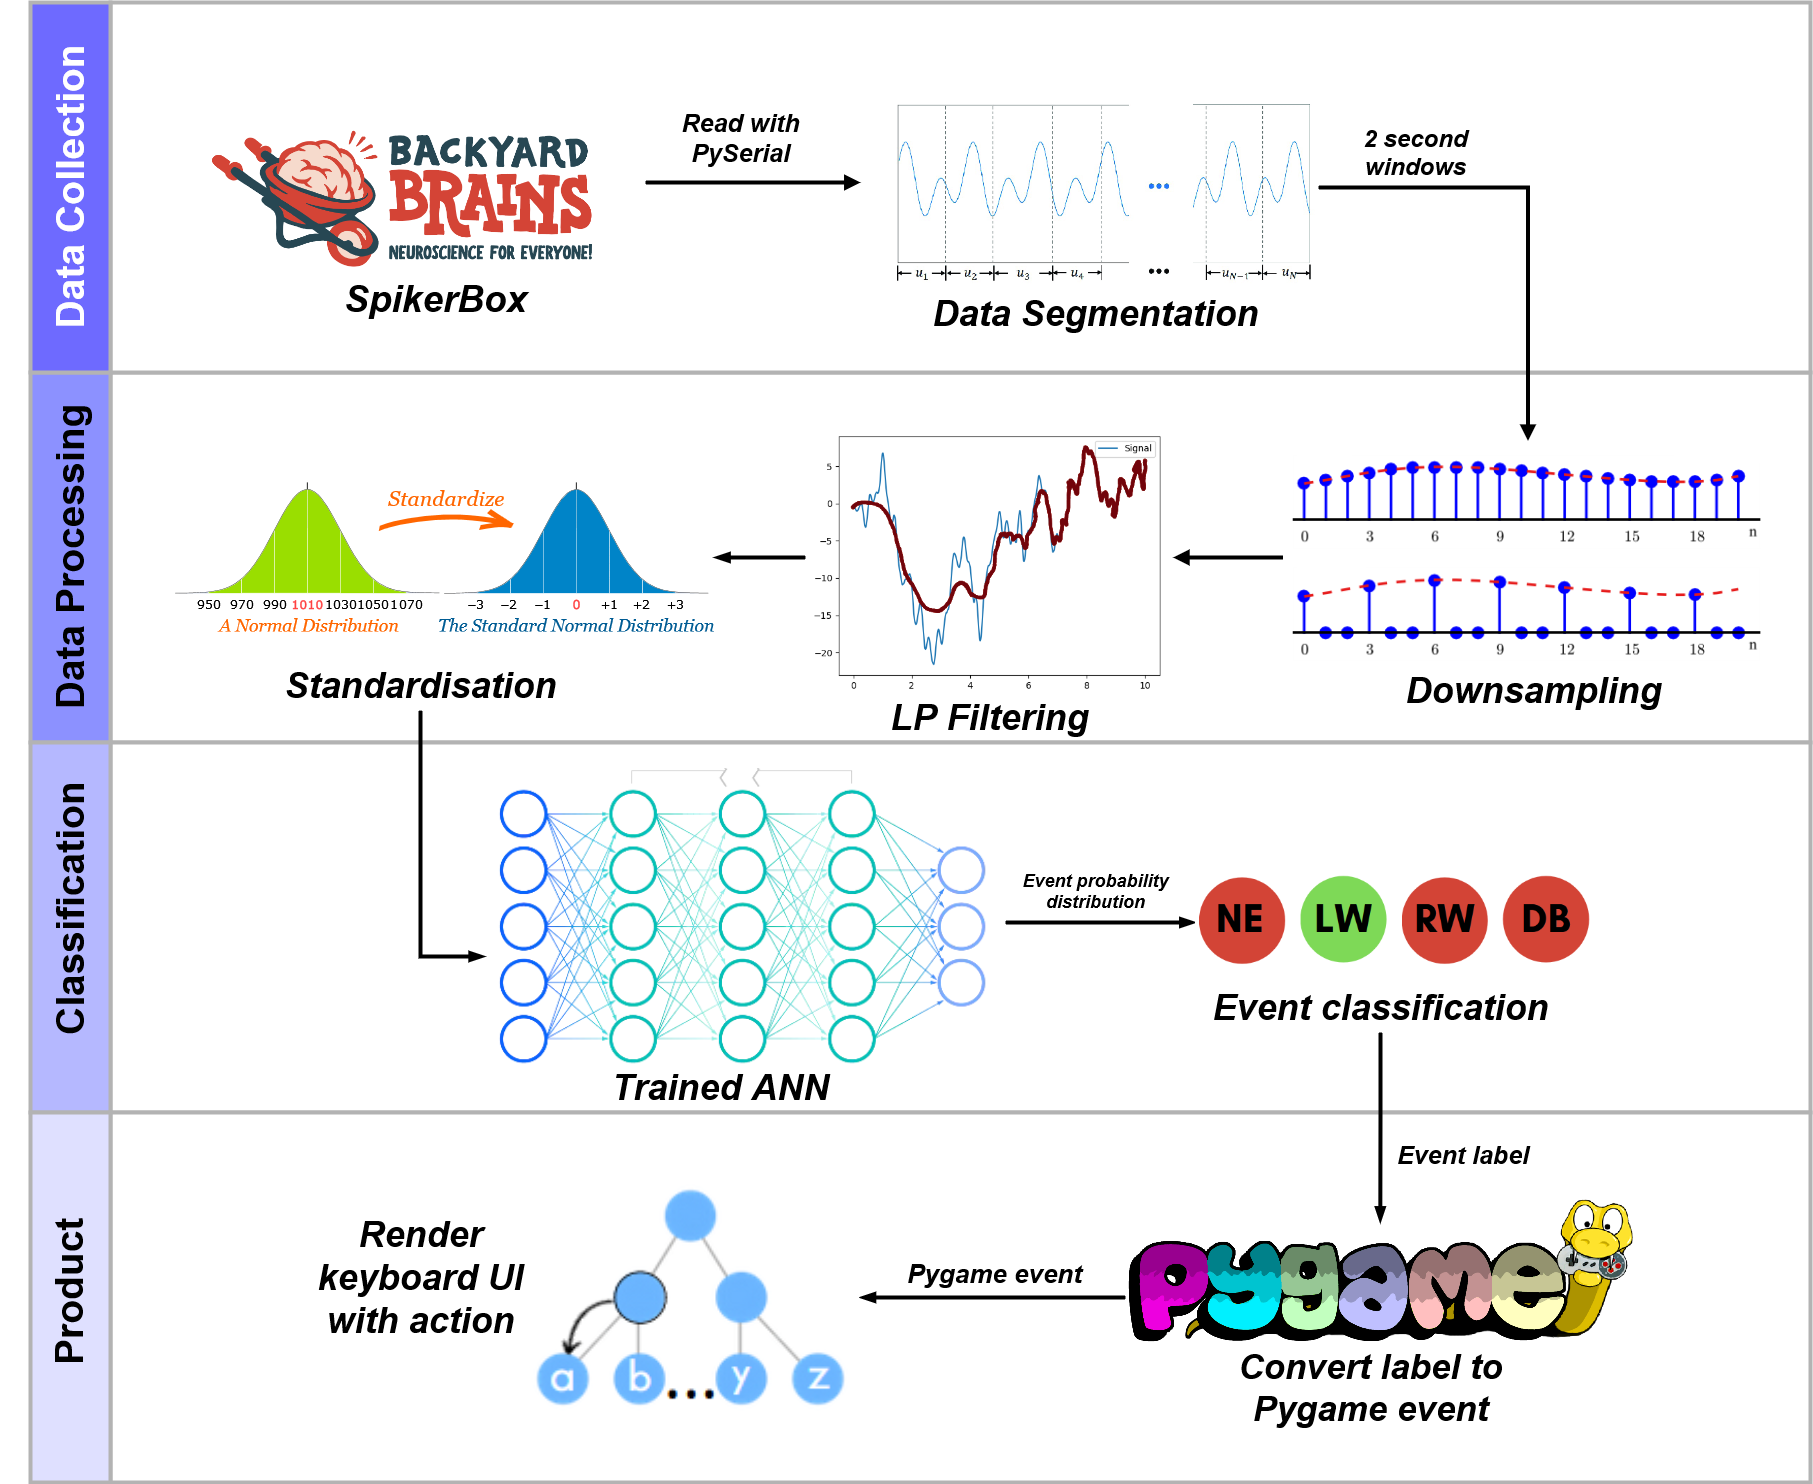

As seen in [figure 1](#Figure-1:-Data-flow-Diagram), the final implementation consists of four distinct stages, bridging the gap between physics and data science. The physics colleagues designed and evaluated digital filters to de-noise SpikerBox data, finding that the Butterworth low-pass filter provided the ideal balance between project requirements and computational cost. Three machine learning classification schemes were evaluated using graphical, qualitative and quantitative methods. With consideration to the end-user, speed was selected as a key metric for model analysis as the keyboard should have minimal delay between action execution and realization in the virtual environment. Moreover, the classification model must be generalisable and demonstrate a high degree of accuracy across all users in order to be a viable solution. Finally, a virtual keyboard requires a low false discovery rate (FDR) as misidentifying inputs would be more detrimental to user-experience than a non-event. Using the aforementioned criteria, it was determined that an artificial neural network (ANN) was the optimal classification model for a virtual keyboard. 

## 2. Aim and Background

### 2.1 Problem

Every day, hundreds of people around the world are diagnosed with motor neurone diseases. ("What is ALS/MND?", 2022).
Patients often have trouble communicating, mostly due to the damage which is caused to the neurons responsible for the functioning of the mouth, tongue and/or larynx. They also often have difficulty using their hands due to a weak grip, muscle cramps and twitches. As a result, patients have trouble using input devices such as keyboards that require hands as well as alternative methods like speech-to-text.


### 2.2 Aim

Our goal was to provide an alternate method for patients with limited motor function and speech to communicate and type. We decided to develop an efficient and intuitive virtual keyboard layout which would use eye movements as input, as this is one of the only modes of communication retained by patients. Minimization of user fatigue was a key goal in the design of the product, as sick patients using it would be more prone to fatigue than the average person.

### 2.3 Background

#### 2.3.1 SpikerBox and Electrooculography (EOG)

As a result of its bioelectromagnetic complexities, a potential exists between the cornea and retina in the eye. This system can effectively be modeled as a single dipole in which motion of the eye results in a change of dipole orientation, inducing a measurable change in the electric potential field it generates. When situated between two electrodes placed on opposite sides of the eye, this change in potential produces a characteristic signal known as an electrooculogram (EOG) (Bulling 2009). 

The SpikerBox, a low cost, open-source bio amplifier with EOG capabilities, was utilized for data acquisition. As each eye movement has a characteristic waveform and amplitude pattern, motion such as left and right gazes as well as blinks and winks can be differentiated using information encoded in the EOG spike signal. On the basis, it is possible to classify and assign eye movements to a discrete set of user-inputs to interact with virtual environments.


#### 2.3.2 Classification and User Interface

To generate control commands for the virtual keyboard from the time-series of EOG data, intentional eye movements were classified in real-time. In addition to demonstrating a high degree of fidelity and efficiency, the implemented classification scheme must be flexible and adaptive. For this reason, three machine learning classification schemes (feed-forward ANN, Support Vector Machine (SVM) and Random Forest) were evaluated with the optimal scheme being employed in the final solution. A Pygame-based UI that is fed event labels in real-time renders the virtual keyboard layout and updates according to the user input.

## 3. Methods


Our method involved a multidisciplinary integration between three different disciplines: physics, data science, and software. Although each discipline contributed to all sections, there was a stronger need for physics students in the data collection/pre-processing phase, data students in the pre-processing/classification phase, and software students in the keyboard UI stage.

### 3.1. Data Collection

The first stage of our method is data collection.

The EOG signal is measured with a SpikerBox, which has a sampling rate of 10kHz. An electrode was placed on either side of the eyes and another under the ear, which transfer the signal to the device then to a laptop via USB where it is analyzed.

Data was collected using an [custom developed interface](#Appendix-Figure-3:-Data-Collection-Mechanism) involving the user following a green circle around the screen which at random intervals displays one of the three actions (left wink, right wink or double blink). The random movement of the circle simulates the eye movement of the user when using the product, which will be traveling around the keyboard looking for the next letter to type. Hence, this makes the data collected more realistic, thus increasing the performance of classification when transferred over to real life data.

In [1]:
import os
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import signal
import seaborn as sns
from sklearn import svm
from xgboost import XGBRFClassifier
import random

import warnings
warnings.filterwarnings('ignore')

# Disable GPU (recommended if erroring due to running out of memory)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)

print("Package import successful")

Package import successful


In [2]:
# CONFIG

EVENT_ID_MAP = {
    None: 0,
    "L": 1,
    "R": 2,
    "S": 3,
}
EVENT_ID_LETTER_MAP = {EVENT_ID_MAP[i]:i for i in EVENT_ID_MAP}

EVENT_COLOR_MAP = {
    None: "black",
    "L": "red",
    "R": "blue",
    "S": "green",
}

EVENT_ID_NAME_MAP = {
    0: "Nothing",
    1: "Left Wink",
    2: "Right Wink",
    3: "Dbl Blink",
}

BRAINBOX_SAMPLE_RATE = 10000

DOWNSAMPLE_RATE = 100

FILTER_DATA = True
FILTER_CUTOFF = 7

NORMALISE_DATA = True

EVENT_LENGTH = 2 # length of a given event sequence in seconds
EVENT_SAMPLE_COUNT = int(EVENT_LENGTH * BRAINBOX_SAMPLE_RATE / DOWNSAMPLE_RATE) # size of event in samples

EVENT_START = -0.75
EVENT_START_OFFSET = int(EVENT_START * BRAINBOX_SAMPLE_RATE / DOWNSAMPLE_RATE)

EVENT_END = -0.25
EVENT_END_OFFSET = int(EVENT_END * BRAINBOX_SAMPLE_RATE / DOWNSAMPLE_RATE)

INPUT_SHAPE = (EVENT_SAMPLE_COUNT,)
OUTPUT_SHAPE = len(EVENT_ID_MAP)  # number of categories (including None)

EVENTS_PATH = "./data/events/"
SAMPLES_PATH = "./data/waves/"

FILE_NAMES_ALL = [
    "DATA_2022-05-13_Josh_0001_3_1652400625",
    "DATA_2022-05-13_Josh_0001_3_1652400939",
    "DATA_2022-05-13_Josh_0001_4_1652401267",
    "DATA_2022-05-13_Josh_0001_4_1652401740",
    "DATA_2022-05-13_Josh_0001_5_1652405337",
    "DATA_2022-05-13_Josh_0001_5_1652405637",
    "DATA_2022-05-13_Josh_0001_6_1652406023",
    "DATA_2022-05-13_Josh_0001_6_1652406202",
    "DATA_2022-05-13_Josh_0001_7_1652406589",
    "DATA_2022-05-13_Josh_0001_7_1652406788",
    "DATA_2022-05-13_Josh_0001_8_1652407331",
    "DATA_2022-05-13_Josh_0001_8_1652407508",
]

In [3]:
def load_sample_data(file_path:str):
    """" Reads brainbox sample/spike data into a data frame """
    samples_df = pd.read_csv(
        f"{file_path}.csv",
    )

    # Sort because some samples are not written in order
    samples_df = samples_df.sort_values("time_sec", ascending=True)
    samples_df.reset_index(drop=True, inplace=True)

    return samples_df

In [4]:
def load_event_data(file_path:str, event_id_map:dict, event_color_map:dict):
    """ Reads brainbox event data into a data frame """

    events_df = pd.read_csv(
        f"{file_path}.csv",
        names=["time_sec", "event_letter", "event_name"],
        header=0,
    )

    events_df["event_id"] = events_df["event_letter"].map(event_id_map)
    events_df["event_color"] = events_df["event_letter"].map(event_color_map)

    return events_df

In [5]:
def merge_samples_events(
    samples_df,
    events_df,
    event_start:float,
    event_end:float,
    event_id_map:dict,
    event_color_map:dict,
):
    """
    Merges the sample and event dataframes.

    Events will be assigned to individual samples within a specified time range around the market.
    """
    # Add target classification event to each sample
    merge_df = samples_df.copy()

    # Default is None (no event)
    merge_df["event_letter"] = None
    merge_df["event_name"] = "Nothing"
    merge_df["event_id"] = event_id_map[None]
    merge_df["event_color"] = event_color_map[None]
    #print(sample_100_df)

    # Assign all events within range around their event marker
    for idx,row in events_df.iterrows():
        # Skip blinks for now
        # if row["event_type"] not in ["Left", "Right"]:
        #     continue

        event_interval = (merge_df["time_sec"] > (row["time_sec"] + event_start))
        event_interval &= (merge_df["time_sec"] < (row["time_sec"] + event_end))
        
        merge_df.loc[event_interval,"event_id"] = row["event_id"]
        merge_df.loc[event_interval,"event_name"] = row["event_name"]
        merge_df.loc[event_interval,"event_color"] = row["event_color"]

    return merge_df

### 3.2. Data Preprocessing

Our data pre-processing pipeline consists of four steps. This stage prepares the collected data in a form ready for input the machine learning models.

#### 3.2.1 Downsampling

The first step of preprocessing is to mean-downsample the wave stream by a factor of 100, reducing the sample rate of the waveform from 10kHz to 100Hz. This transformation preserves the majority of the wave structure whilst simultaneously reducing the time it takes to perform the later data transformations as there are 100 times less values. Downsampling also reduces the risk of overfitting in the model as the input size is smaller.

In [6]:
def data_downsample(sample_df, n=100):
    """
    Downsamples the wave data (not events) to 1/nth of a second by taking mean sample over that period.
    """
    # Crop size to allow downsampling
    sample_df = sample_df[:len(sample_df) - (len(sample_df)%n)]
    
    return pd.DataFrame({
        "time_sec": np.min(np.array(sample_df["time_sec"]).reshape(-1,n), 1),
        "sample": np.mean(np.array(sample_df["sample"]).reshape(-1,n), 1),
    })

#### 3.2.2 Data Segmentation

The next step of preprocessing is to splice the continuous stream of waveform data into chunks of length 2 seconds. This value was chosen as it was found to be long enough to contain the entire perturbation caused by a given action (e.g. Double Blink, Left Wink). This transformation is crucial as it generates input vectors of a standardized length (2 seconds x 100Hz = 200 values), allowing us to pass the waveform input directly into our machine learning model of choice.

In [7]:
def data_segmentation(merge_df, event_sample_count:int, filter_data:bool):
    """
    Returns a list of each time series sequence labelled by the event.
    """
    print("Transforming data into individual segments...")

    seqs = []
    labels = []

    for idx,row in merge_df[:-event_sample_count].iterrows():
        label = row["event_id"]
        if label is None:
            label = -1
        labels.append(label)

        seq = list(merge_df["sample"][idx:idx+event_sample_count])
        seqs.append(seq)

    seqs = np.array(seqs)
    labels = np.array(labels)

    print(f"Transformed into {seqs.shape[0]} segments of size {seqs.shape[1]}")
    
    return (seqs, labels)

#### 3.2.3 Filtering

In typical operating environments, EOG signals can become contaminated by artifacts arising from muscle contractions, head-movements, and electromagnetic disturbances from power-line interference. To avoid inclusion of unwanted noise, it is necessary to remove high frequency contributions from these sources, while retaining the original signal of interest. A frequency spectrum analysis of raw EOG signals revealed that eye-movement is encoded within the sub-10 Hz range. On this basis, a low-pass Butterworth filter was selected for signal denoising.Optimal cut-off frequency was empirically determined to be 7Hz, while a fifth order filter provided the best trade-off between steepness of roll-off and computational cost. 

In [8]:
# Butterworth filter
def data_filter(rawData, order:int=5, cutOff:int=7, Fs:int=10000):
    """
    Low pass
    cutOff in Hz
    """
    b, a = signal.butter(order, Wn=cutOff/(Fs/2)) 
    # Zero Phase double filter
    filteredSignal = signal.filtfilt(b, a, rawData)
    return filteredSignal

#### 3.2.4 Normalization

Another preprocessing step is the normalization of the signal. The signal can be influenced by factors such as electrode placement next to the eyes, and different individuals which can vary between data collection sessions. By normalizing the signals with a reference value, it is possible to more accurately compare and identify events produced. This is required to perform classification on these events.

In [9]:
def data_normalise(data):
    return (data - data.mean()) / data.std()

##### 3.2.5. Model preparation

We now combine all the above pre-processing steps with the collected wave files in preparation for model training. This may take 1-2 minutes.

In [10]:
print("Data Preprocessing\n")
files_data_all = []
files_labels_all = []

for file_name in FILE_NAMES_ALL:
    start_time = time.time()

    print(f"Loading sample file '{file_name}'")
    samples_df = load_sample_data(SAMPLES_PATH + file_name)
    print(f"Loaded {len(samples_df)} samples")
    
    print(f"Downsampling @ n={DOWNSAMPLE_RATE}")
    samples_df = data_downsample(samples_df, n=DOWNSAMPLE_RATE)
    print(f"Downsampled to {len(samples_df)} samples")

    print(f"Loading event file '{file_name}'")
    events_df = load_event_data(
        file_path = EVENTS_PATH + file_name,
        event_id_map = EVENT_ID_MAP,
        event_color_map = EVENT_COLOR_MAP,
    )
    print(f"Loaded {len(events_df)} events")

    print(f"Merging samples and events")
    merge_df = merge_samples_events(
        samples_df, events_df,
        event_start = EVENT_START,
        event_end = EVENT_END,
        event_id_map = EVENT_ID_MAP,
        event_color_map = EVENT_COLOR_MAP,
    )
#     print("Merge complete")

    # Segment data for ML model input
    seq_data, seq_labels = data_segmentation(
        merge_df,
        event_sample_count=EVENT_SAMPLE_COUNT,
        filter_data=FILTER_DATA,
    )

    # Apply filters before we do the normalisation
    # One reason is that mains 50Hz will increase std for that sample
    if FILTER_DATA:
        for i,seq in enumerate(seq_data):
            seq_data[i] = data_filter(seq, cutOff=FILTER_CUTOFF, Fs=100) # Account for downsampling

    # Normalise relative to the 2 second interval
    # Note that this method will scale non-actions to have large magnitudes
    if NORMALISE_DATA:
        for i,seq in enumerate(seq_data):
            seq_data[i] = data_normalise(seq)

    files_data_all.append(seq_data)
    files_labels_all.append(seq_labels)

    print(f"Loaded and preprocessed file data in {time.time()-start_time:.2f}s")
    print("")
    
print("Finished data preprocessing")

Data Preprocessing

Loading sample file 'DATA_2022-05-13_Josh_0001_3_1652400625'
Loaded 1924764 samples
Downsampling @ n=100
Downsampled to 19247 samples
Loading event file 'DATA_2022-05-13_Josh_0001_3_1652400625'
Loaded 52 events
Merging samples and events
Transforming data into individual segments...
Transformed into 19047 segments of size 200
Loaded and preprocessed file data in 6.00s

Loading sample file 'DATA_2022-05-13_Josh_0001_3_1652400939'
Loaded 1675296 samples
Downsampling @ n=100
Downsampled to 16752 samples
Loading event file 'DATA_2022-05-13_Josh_0001_3_1652400939'
Loaded 42 events
Merging samples and events
Transforming data into individual segments...
Transformed into 16552 segments of size 200
Loaded and preprocessed file data in 5.23s

Loading sample file 'DATA_2022-05-13_Josh_0001_4_1652401267'
Loaded 2180967 samples
Downsampling @ n=100
Downsampled to 21809 samples
Loading event file 'DATA_2022-05-13_Josh_0001_4_1652401267'
Loaded 53 events
Merging samples and event

### 3.3. Models

#### 3.3.1 ANN

Artificial neural networks (ANN) attempt to simulate the network of neurons in the human brain to develop algorithms for models.The keras/tensorflow package was used to develop the neural network architecture. A common approach to handle the sequence dependence of time-series data is to use a recurrent network.  However, as a result of segmenting data into independent windows of fixed size, a feed-forward network (with 200-wide vector input and 4-vector output) was more appropriate. Through experimentation, the optimal network was designed with an initial dropout layer and two fully connected, dense layers.  

In [27]:
HIDDEN_LAYER_1_SIZE = 128
HIDDEN_LAYER_2_SIZE = 128

def get_model_ann(hidden_layer_1_size=64, hidden_layer_2_size=16):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=INPUT_SHAPE),
        tf.keras.layers.Dropout(.50, input_shape=INPUT_SHAPE),
        tf.keras.layers.Dense(hidden_layer_1_size, activation='relu'),
        tf.keras.layers.Dense(hidden_layer_2_size, activation='relu'),
        tf.keras.layers.Dense(OUTPUT_SHAPE)
    ])
    return model

#### 3.3.2  SVM

Support vector machines are statistical and machine-learning techniques with the primary goal of prediction. They can be applied to continuous, binary, and categorical outcomes analogous to Gaussian, logistic, and multinomial regression (Guenther and Schonlau, 2016).
By visual inspection of filtered signals, it appeared that the various classes of event were linearly separable. On this basis, the segmented data windows were passed directly into the SVM model for training without prior feature extraction.

In [12]:
def get_model_svm():
    clf = svm.SVC()
    return clf

#### 3.3.3 Random-Forest with XGBoost 

Random-Forests are an ensemble learning method based on decision trees (Breiman & Cutler, 2006). XGBoost performs additive optimization in functional space (Chen & Guestrin, 2016).
We trained 16 XGBoosted Random-Forests using the xgboost module, with varying hyper-parameters like number of decision trees and number of features. The performance of these classifiers was compared using boxplots.


In [13]:
RF_NUM_TREES = 10
RF_NUM_FEATURES = 0.4
RF_SUBSAMPLE = 0.9

def get_model_rf(num_trees=50, num_features=0.1, subsample=0.9):
    return XGBRFClassifier(
        n_estimators=num_trees,
        subsample=subsample,
        colsample_bynode=num_features,
    )

### 3.4. Evaluation Strategies

The classifier was evaluated using various qualitative, quantiative, and graphical strategies designed to enhance the user experience of the virtual keyboard. 

#### 3.4.1. Qualitative

To evaluate the product on a qualitative basis, we performed a number of live tests during lab sessions where we analysed various qualitative metrics including easy of use, and user fatigue. This was achieved by giving the user the task of writing "Hello, World!" while describing aloud their thoughts regarding their experience. After completion, we then asked for other feedback, particularly their perceived fatigue in the short and long term. The results of these tests can be seen in [section 4.1.1](#4.1.1.-Qualitative-Evaluation-Results).

##### 3.4.2. Accuracy

Accuracy is defined as how often events (or lack thereof) are classified correctly - $(TP+TN)/(TP+TN+FP+FN)$. Accuracy was chosen as our first quantiative metric by working under the assumption that users would like their events to be recognised. In particular, they would strongly dislike events to be misclassified, as this would require them spending more time correcting the mistake compared to simply repeating the action. Hence, we would like this metric to be as high as possible.

##### 3.4.3. False Discovery Rate

FDR (False Discovery Rate) is the rate of falsely classified events compared to the total number of recognised events - $(FP)/(FP+TP)$. In the context of the project, this represents the rate at which an unintentional eye movement was classified as a valid input.
This is detrimental for a keyboard as every accidental input would require correction by the user which would cause great frustration. Hence, it is ideal for this quantatative metric to be as low as possible.


##### 3.4.4. k-fold Cross Validation

The above metrics were evaluated using k-fold cross validation, which is a technique involving splitting the dataset into k groups and calculating a test accuracy within each group. For this project, a k-value of 12 was used (one for each recording session) as this ensured there was no overlap between folds which prevents overfitting to a particular recording session (effectively leave-one-out-CV on a per-file basis). This evaluation method was chosen as it is able to produce relatively accurate validation results on a limited dataset compared to real world performance. Boxplots were used as a graphical method to compare the above metrics for both hyperparameter analysis and final model selection.

In [14]:
ANN_EPOCHS = 10
ANN_OPTIMIZER = 'adam'

def train_model_ann(model, train_data, train_labels, test_data, test_labels):
    subset = np.random.random(len(train_data)) < 0.1
    print("Training ANN with", sum(subset), "samples")
    start_time = time.time()
    
    # Trains model and returns history dict
    model.compile(
        optimizer=ANN_OPTIMIZER,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    history = model.fit(
        train_data[subset],
        train_labels[subset],
        epochs=ANN_EPOCHS,
        validation_data=(test_data, test_labels)
    #     batch_size=16
    )

    print(f"Completed training ANN in {time.time()-start_time:.2f}s")

    print(f"Generating predictions for test set with size", len(test_labels))
    start_time = time.time()
    
    test_out = model.predict(test_data)
    test_probs = tf.nn.softmax(test_out, axis=1)
    test_pred = np.argmax(test_probs, axis=1)
    
    print(f"Generated predictions in {time.time()-start_time:.2f}s")

    # Return predictions for test set
    return test_pred

In [15]:
def train_model_svm(model, train_data, train_labels, test_data, test_labels):
    subset = np.random.random(len(train_data)) < 0.1
    print("Training SVM with", sum(subset), "samples")
    start_time = time.time()
    
    model.fit(train_data[subset], train_labels[subset])
    
    print(f"Completed training SVM in {time.time()-start_time:.2f}s")

    print(f"Generating predictions for test set with size", len(test_labels))
    start_time = time.time()
    
    test_pred = model.predict(test_data)

    print(f"Generated predictions in {time.time()-start_time:.2f}s")
    
    # Return predictions for test set
    return test_pred

In [16]:
# Random Forest Training and Testing
def train_model_rf(model, train_data, train_labels, test_data, test_labels):
    subset = np.random.random(len(train_data)) < 0.1
    print("Training XGBRandomForest with", sum(subset), "samples")
    start_time = time.time()
    
    model.fit(train_data[subset], train_labels[subset])
    
    print(f"Completed training XGBRandomForest in {time.time()-start_time:.2f}s")
    
    print(f"Generating predictions for test set with size", len(test_labels))
    
    start_time = time.time()
    
    test_pred = model.predict(test_data)
    
    print(f"Generated predictions in {time.time()-start_time:.2f}s")

    # Return predictions for test set
    return test_pred

In [17]:
def confusion_matrix(label_pred, label_true):
    # Rows are "real" labels
    # Columns are "predicted" labels
    conf = tf.math.confusion_matrix(
        label_pred,
        label_true
    )

    return conf

In [18]:
# 12 folds with all files
# ~1 minute per fold -> ~12 minutes
CV_K = len(FILE_NAMES_ALL)

cv_conf_ann = []
cv_conf_svm = []
cv_conf_rf = []

def get_cv_fold(k):
    # Get training data/labels
    train_data = np.concatenate(files_data_all[0:k] + files_data_all[k+1:])
    train_labels = np.concatenate(files_labels_all[0:k] + files_labels_all[k+1:])
    print(train_data.shape, train_labels.shape)

    # Get testing data/labels
    test_data = files_data_all[k]
    test_labels = files_labels_all[k]
    print(test_data.shape, test_labels.shape)

    return train_data, train_labels, test_data, test_labels

    
start_time_training = time.time()
for k in range(CV_K):
    print(f"Fold #{k+1}/{CV_K}")
    start_time = time.time()
    
    train_data, train_labels, test_data, test_labels = get_cv_fold(k)

    # Train and test ANN
    model_ann = get_model_ann(hidden_layer_1_size = HIDDEN_LAYER_1_SIZE, hidden_layer_2_size = HIDDEN_LAYER_2_SIZE)
    test_pred_ann = train_model_ann(model_ann, train_data, train_labels, test_data, test_labels)
    conf_ann = confusion_matrix(test_pred_ann, test_labels)
    cv_conf_ann.append(conf_ann)

    # Train and test SVM
    model_svm = get_model_svm()
    test_pred_svm = train_model_svm(model_svm, train_data, train_labels, test_data, test_labels)
    conf_svm = confusion_matrix(test_pred_svm, test_labels)
    cv_conf_svm.append(conf_svm)

    # Train and Test XGBRandomForest
    model_xgbrf = get_model_rf(num_trees=10, num_features=0.4)
    test_pred_xgbrf = train_model_rf(model_xgbrf, train_data, train_labels, test_data, test_labels)
    conf_xgbrf = confusion_matrix(test_pred_xgbrf, test_labels)
    cv_conf_rf.append(conf_xgbrf)

    print(f"Done fold in {time.time() - start_time:.2f}s\n")

print(f"Training complete in {time.time() - start_time_training:.2f}s")

Fold #1/12
(203367, 200) (203367,)
(19047, 200) (19047,)
Training ANN with 20405 samples
Epoch 1/10
638/638 [==============================] - 2s 3ms/step - loss: 0.3698 - accuracy: 0.8752 - val_loss: 0.2084 - val_accuracy: 0.9276
Epoch 2/10
638/638 [==============================] - 2s 3ms/step - loss: 0.2387 - accuracy: 0.9186 - val_loss: 0.1601 - val_accuracy: 0.9481
Epoch 3/10
638/638 [==============================] - 2s 3ms/step - loss: 0.2122 - accuracy: 0.9270 - val_loss: 0.1446 - val_accuracy: 0.9513
Epoch 4/10
638/638 [==============================] - 2s 4ms/step - loss: 0.1971 - accuracy: 0.9323 - val_loss: 0.1385 - val_accuracy: 0.9522
Epoch 5/10
638/638 [==============================] - 3s 4ms/step - loss: 0.1878 - accuracy: 0.9348 - val_loss: 0.1363 - val_accuracy: 0.9521
Epoch 6/10
638/638 [==============================] - 2s 3ms/step - loss: 0.1739 - accuracy: 0.9382 - val_loss: 0.1230 - val_accuracy: 0.9574
Epoch 7/10
638/638 [==============================] - 2s 4m

610/610 [==============================] - 3s 4ms/step - loss: 0.2445 - accuracy: 0.9209 - val_loss: 0.1845 - val_accuracy: 0.9397
Epoch 3/10
610/610 [==============================] - 2s 3ms/step - loss: 0.2188 - accuracy: 0.9278 - val_loss: 0.1837 - val_accuracy: 0.9379
Epoch 4/10
610/610 [==============================] - 2s 3ms/step - loss: 0.2032 - accuracy: 0.9313 - val_loss: 0.1731 - val_accuracy: 0.9443
Epoch 5/10
610/610 [==============================] - 2s 4ms/step - loss: 0.1962 - accuracy: 0.9334 - val_loss: 0.1582 - val_accuracy: 0.9466
Epoch 6/10
610/610 [==============================] - 2s 3ms/step - loss: 0.1817 - accuracy: 0.9366 - val_loss: 0.1536 - val_accuracy: 0.9465
Epoch 7/10
610/610 [==============================] - 2s 4ms/step - loss: 0.1775 - accuracy: 0.9384 - val_loss: 0.1487 - val_accuracy: 0.9478
Epoch 8/10
610/610 [==============================] - 3s 5ms/step - loss: 0.1716 - accuracy: 0.9397 - val_loss: 0.1502 - val_accuracy: 0.9507
Epoch 9/10
610/61

635/635 [==============================] - 2s 4ms/step - loss: 0.2050 - accuracy: 0.9309 - val_loss: 0.2342 - val_accuracy: 0.9320
Epoch 5/10
635/635 [==============================] - 2s 3ms/step - loss: 0.1952 - accuracy: 0.9326 - val_loss: 0.2345 - val_accuracy: 0.9329
Epoch 6/10
635/635 [==============================] - 2s 2ms/step - loss: 0.1859 - accuracy: 0.9372 - val_loss: 0.2323 - val_accuracy: 0.9296
Epoch 7/10
635/635 [==============================] - 2s 3ms/step - loss: 0.1791 - accuracy: 0.9386 - val_loss: 0.2344 - val_accuracy: 0.9301
Epoch 8/10
635/635 [==============================] - 2s 4ms/step - loss: 0.1727 - accuracy: 0.9409 - val_loss: 0.2332 - val_accuracy: 0.9301
Epoch 9/10
635/635 [==============================] - 2s 3ms/step - loss: 0.1711 - accuracy: 0.9412 - val_loss: 0.2342 - val_accuracy: 0.9285
Epoch 10/10
635/635 [==============================] - 2s 4ms/step - loss: 0.1657 - accuracy: 0.9417 - val_loss: 0.2255 - val_accuracy: 0.9321
Completed traini

#### 3.4.5. Hyperparameter Analysis

To optimise the performance models within the selected metrics, we performed hyperparameter analysis on both the ANN and Random Forest models. For the ANN, we varied the size of both hidden layers. For random forest we varied both the number of trees and number of features.

Note full test will take >>1hr, see the [appendix](#EXAMPLE-Figure-2:-(above)) for an example output.

In [ ]:
#XGBoosted Random Forest Classifier setup
def hp_analyisis(hp_list, get_model_func, train_model_func):
    print("Hyperparam analysis RF")
    start_time_hp_all = time.time()
    print(hp_list)
    
    cv_conf_rf_all = []

    for hp in hp_list:
        print(f"Testing hp={hp}")
        start_time_all = time.time()

        cv_conf_rf = []

        for k in range(CV_K):
            print(f"Fold #{k+1}/{CV_K}")
            start_time = time.time()

            train_data, train_labels, test_data, test_labels = get_cv_fold(k)

            # Train and test model with particular hyperparam
            model = get_model_func(**hp)
            test_pred = train_model_func(model, train_data, train_labels, test_data, test_labels)
            conf = confusion_matrix(test_pred, test_labels)
            cv_conf_rf.append(conf)

            print(f"Done fold in {time.time() - start_time:.2f}s\n")
        
        cv_conf_rf_all.append(cv_conf_rf)

        print(f"Done HP test in {time.time() - start_time_all:.2f}s\n")

    print(f"Completed hyperparameter analysis in {time.time() - start_time_hp_all:.2f}s\n")
    
    return np.array(cv_conf_rf_all)

In [ ]:
# Run hyperparam analyis for the following 4 params

# CV_ANN_H1_SIZE = [16, 32, 64] 
CV_ANN_H1_SIZE = [8, 16, 32, 64, 128]

# CV_ANN_H2_SIZE = [8, 16, 32]
CV_ANN_H2_SIZE = [8, 16, 32, 64, 128]

# CV_RF_N_TREES = [3, 5, 8]
CV_RF_N_TREES = [5, 10, 50, 100, 175, 250]

# CV_RF_N_FEATURES = [0.1, 0.5, 0.8]
CV_RF_N_FEATURES = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

hp_list_ann_h1s = [{"hidden_layer_1_size":h1} for h1 in CV_ANN_H1_SIZE]
cv_conf_ann_h1s = hp_analyisis(hp_list_ann_h1s, get_model_ann, train_model_ann)

hp_list_ann_h2s = [{"hidden_layer_2_size":h2} for h2 in CV_ANN_H2_SIZE]
cv_conf_ann_h2s = hp_analyisis(hp_list_ann_h2s, get_model_ann, train_model_ann)

hp_list_rf_ntrees = [{"num_trees":nt} for nt in CV_RF_N_TREES]
cv_conf_rf_ntrees = hp_analyisis(hp_list_rf_ntrees, get_model_rf, train_model_rf)

hp_list_rf_nfeatures = [{"num_features":nf} for nf in CV_RF_N_FEATURES]
cv_conf_rf_nfeatures = hp_analyisis(hp_list_rf_nfeatures, get_model_rf, train_model_rf)

print("Done")

In [28]:
# Plot hyperparam analysis results
def hp_boxplot(conf_list, hp_list, title, hp_name, row_num=0, row_count=1):
    acc_list_all = []
    for conf_list_hp in conf_list:
        acc_list = []
        for conf in conf_list_hp:
            overall_total = sum(sum(conf))
            overall_correct = sum([conf[i][i] for i in range(len(conf))])
            overall_acc = overall_correct/overall_total
            acc_list.append(overall_acc)
        acc_list_all.append(acc_list)

    fdr_list_all = []
    for conf_list_hp in conf_list:
        fdr_list = []
        for conf in conf_list_hp:
            fp = sum(conf[0][1:])
            tp = sum(sum(conf[1:]))
            fdr_tot = fp/(fp+tp)
            
            fdr_list.append(fdr_tot)
        fdr_list_all.append(fdr_list)

    plt.subplot(row_count,2,row_num*2+1)
    plt.boxplot(acc_list_all, labels=hp_list)
    plt.title(f"{title} (Accuracy)")
    plt.xlabel(hp_name)
    plt.ylabel("Accuracy (%)")

    plt.subplot(row_count,2,row_num*2+2)
    plt.boxplot(fdr_list_all, labels=hp_list)
    plt.title(f"{title} (FDR)")
    plt.xlabel(hp_name)
    plt.ylabel("FDR")

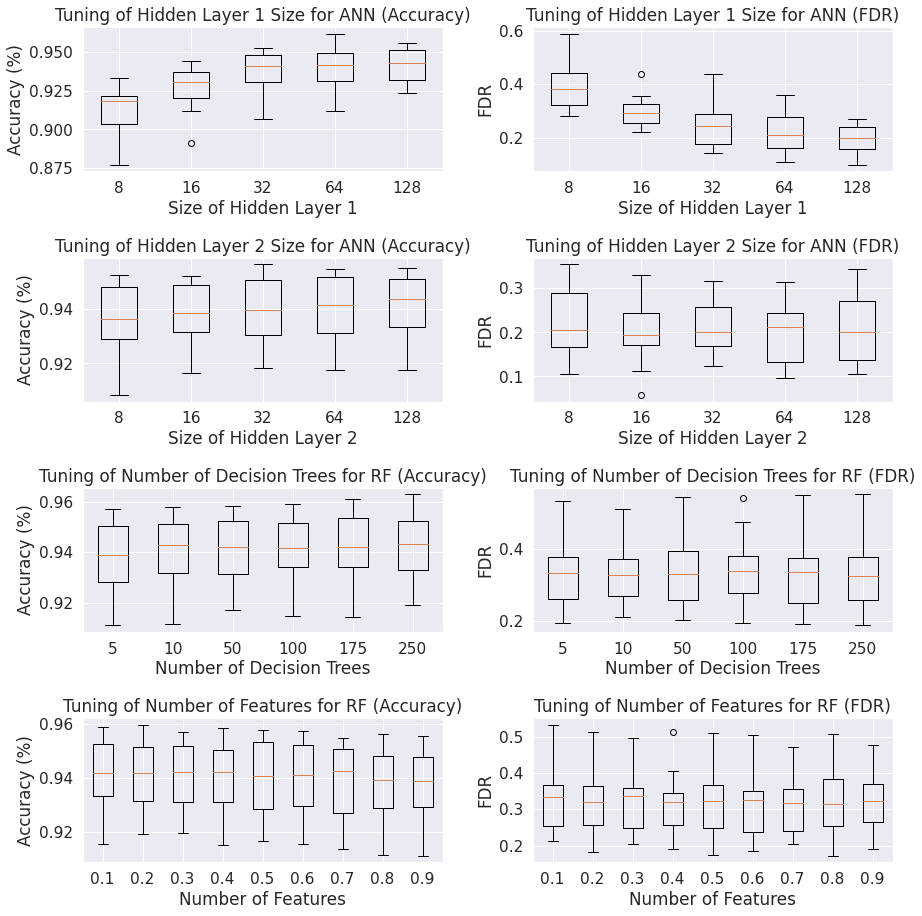

In [55]:
hp_boxplot(
    cv_conf_ann_h1s,
    CV_ANN_H1_SIZE,
    title = "Tuning of Hidden Layer 1 Size for ANN",
    hp_name = "Size of Hidden Layer 1",
    row_num = 0,
    row_count = 4,
)

hp_boxplot(
    cv_conf_ann_h2s,
    CV_ANN_H2_SIZE,
    title = "Tuning of Hidden Layer 2 Size for ANN",
    hp_name = "Size of Hidden Layer 2",
    row_num = 1,
    row_count = 4,
)

hp_boxplot(
    cv_conf_rf_ntrees,
    CV_RF_N_TREES,
    title = "Tuning of Number of Decision Trees for RF",
    hp_name = "Number of Decision Trees",
    row_num = 2,
    row_count = 4,
)

hp_boxplot(
    cv_conf_rf_nfeatures,
    CV_RF_N_FEATURES,
    title = "Tuning of Number of Features for RF",
    hp_name = "Number of Features",
    row_num = 3,
    row_count = 4,
)

plt.subplots_adjust(right = 2, bottom = 0.1, top = 3, wspace=0.25, hspace=0.60)
plt.show()

#### Figure 2: Hyperparameter Analysis (above)

As seen in the figure ([or example figure](#EXAMPLE-Figure-2:-Hyperparameter-Analysis)), the ANN architectures tended to both increase accuracy and decrease FDR with increase layer size. For decision trees the trends were less clear, although the accuracy does seem to drop off below 10 trees and with increasing features, potentially due to over and underfitting respectively.

## 4. Results

### 4.1. Part A

#### 4.1.1. Qualitative Evaluation Results

Initial prototypes revealed that users struggled recognising their position within the keyboard layout due to the lack of colour or other visual cues (see [appendix](#Appendix-Figure-1:-Old-keyboard-design-(no-colours-/-visual-cues)). To resolve this, we added an intuitive colour scheme to the keyboard based on each of the the individual key's functionality (see [appendix](#Appendix-Figure-2:-New-keyboard-design-(visual-cues-+-colour))). This allowed users to easily perceive the difference between nodes meant for navigation, and those meant for typing.

Furthermore, users reported being confused at the duel functionality of the "double blink"/"select" input, which depended on whether or not the user was located on a navigation or typing node. To address this complaint, we added directional indicators on the edges of the tree nodes so it would always be clear the outcome of the various possible inputs.

In the original design, the left and right actions were performed with a sequence of 3 eye movements (e.g. Left action = blink + blink + look left). One user reported irritation and fatigue after extended usage of the keyboard under this particular protocol. Therefore we constructed a new protocol utilising individual eye winks (rather than blinks) which reduced the number of required actions to navigate the keyboard to just a single wink of either the left or right eye. This was also found to increase the speed of navigation, as well as aleviating user fatigue.


#### 4.1.2. CV Evaluation Results

In [20]:
total_conf_ann = np.sum(cv_conf_ann, axis=0)
total_conf_svm = np.sum(cv_conf_svm, axis=0)
total_conf_rf = np.sum(cv_conf_rf, axis=0)

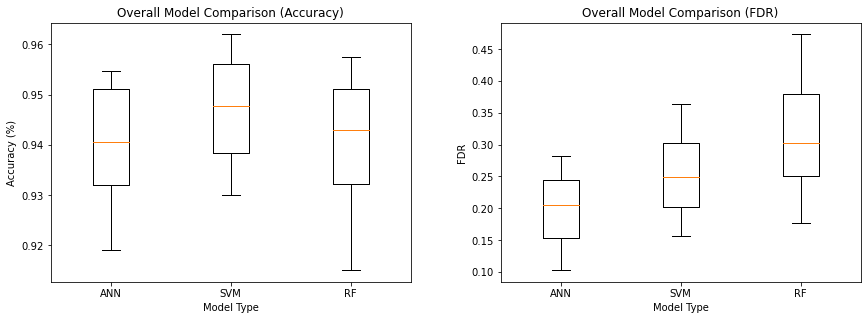

In [23]:
hp_boxplot(
    [cv_conf_ann, cv_conf_svm, cv_conf_rf],
    ["ANN", "SVM", "RF"],
    title = "Overall Model Comparison",
    hp_name = "Model Type"
)

plt.subplots_adjust(right = 2, bottom = 0.1, top = 1, wspace=0.25, hspace=0.50)
plt.show()

#### Figure 3: Model Graphical Boxplot Comparison (above)

As seen in figure 3 ([or example](#EXAMPLE-Figure-3:-Model-Comparison)), all models have similar overall accuracies between 94 and 95%. The ANN model however seems to have a much lower FDR than other models, with RF having the highest. This suggests that the SVM and RF models are more prone to classifying NULL events, which can be detrimental to user experience.

In [24]:
def get_table(conf_array):
    final_table = np.zeros((9,3))
    for index, conf in enumerate(conf_array):
        store = []
        overall_total = sum(sum(conf))
        overall_correct = tf.linalg.trace(conf)
        overall_accuracy = 100*overall_correct/overall_total

        fp = sum(conf[0][1:])
        tp = sum(sum(conf[1:]))
        fdr_tot = fp/(fp+tp) # overall FDR
        
        # overall acc
#         print(overall_accuracy)
        store = np.append(store, overall_accuracy)
        
        # Acc for each event
        for i in range(len(conf)):
            total = sum(conf[i])
            correct = conf[i][i]
            acc_total = 100*(correct/total)
            store = np.append(store, acc_total)
        store = np.append(store, fdr_tot)
        
        # FDR for each event
        for i in range(1,len(conf)):
            fp = sum([r[i] for r in conf])-conf[i,i]
            tp = conf[i,i]
            fdr_event = fp/(fp+tp)
            store = np.append(store, fdr_event)
            
        final_table[:, index] = store
    return final_table

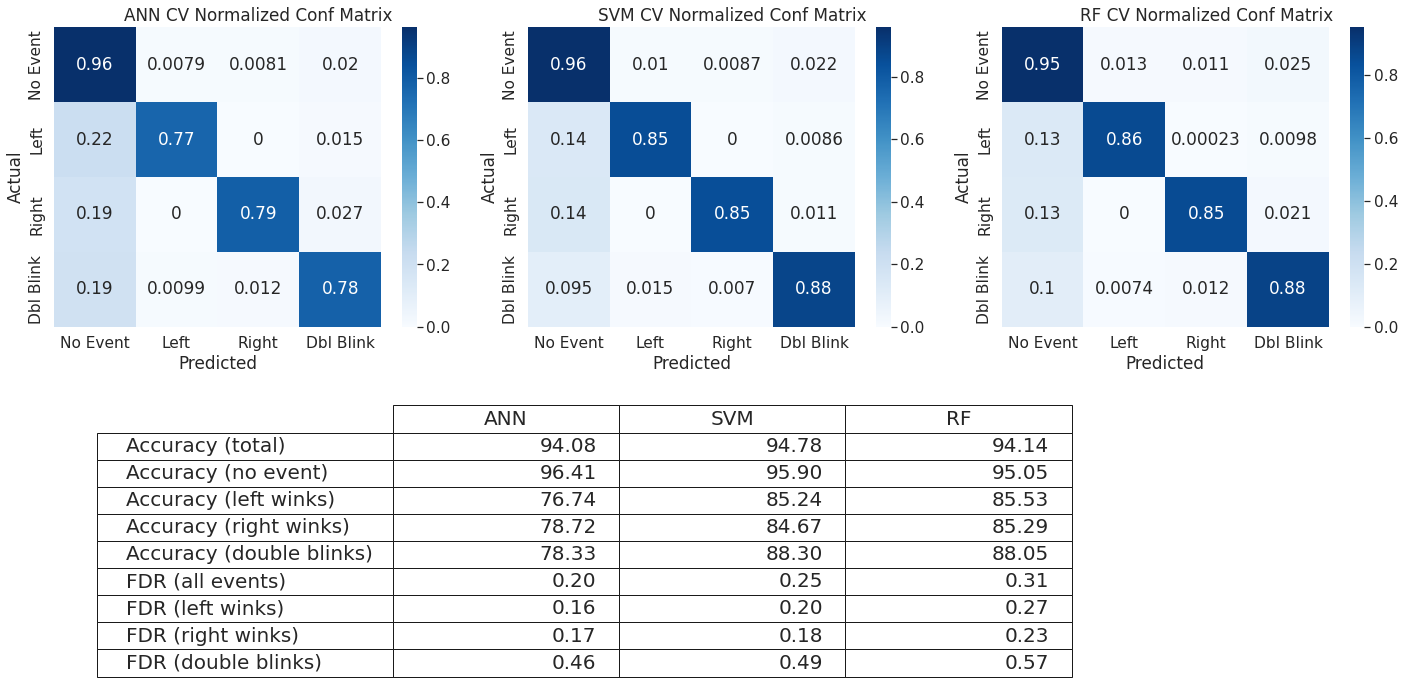

In [25]:
def plot_conf_comparison(models, model_names):
    fig = plt.figure(figsize=(20,10))
    plt.subplots_adjust(wspace=0.1, hspace=0.05)
    sns.set(font_scale=1.4)
    gs = fig.add_gridspec(2,3)
    
    # Normalize plots
    for index, model in enumerate(models):
        normalize = np.sum(model, axis=1)
        model = model/normalize.reshape(-1,1)
        ax = fig.add_subplot(gs[0, index])
        s = sns.heatmap(
            model, annot=True, cmap='Blues', ax=fig.add_subplot(gs[0,index]), 
            xticklabels=['No Event', 'Left', 'Right', 'Dbl Blink'], 
            yticklabels=['No Event', 'Left', 'Right', 'Dbl Blink']
        )
        s.set(xlabel='Predicted', ylabel='Actual')
        ax.set_title(f'{model_names[index]} CV Normalized Conf Matrix')
        ax.xaxis.set_ticklabels(['No Event', 'Left', 'Right', 'Dbl Blink'])
        ax.yaxis.set_ticklabels(['No Event', 'Left', 'Right', 'Dbl Blink'], rotation=0)
        ax.axis('off')
        ax.axis('tight')
    ax = fig.add_subplot(gs[1, :])
    columns = ('ANN', 'SVM', 'RF')
    row_labels = [
        "Accuracy (total)",
        "Accuracy (no event)",
        "Accuracy (left winks)",
        "Accuracy (right winks)",
        "Accuracy (double blinks)",
        "FDR (all events)",
        "FDR (left winks)",
        "FDR (right winks)",
        "FDR (double blinks)"
    ]
    table = get_table(models)
    data = []
    for i in range(9):
        data.append([f"{table[i,0]:.2f}", f"{table[i,1]:.2f}", f"{table[i,2]:.2f}"])
#     data = np.random.random((10,3)) #Insert data for all of the columns as array 
    table = ax.table(cellText=data, colLabels=columns, rowLabels=row_labels, loc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(20) 
    table.scale(0.5, 2)
    ax.axis('tight')
    ax.axis('off')
    fig.tight_layout()
    plt.show()

plot_conf_comparison(
    [total_conf_ann, total_conf_svm, total_conf_rf],
    ['ANN', 'SVM', 'RF']
)

#### Figure 4: Model Quantitative Comparison (above)

As seen in figure 4 ([or example](#EXAMPLE-Figure-4:-Model-Quantitative-Comparison)), all models tend to classify with similar overall accuracy, however ANN is noticibly worse on a per-event basis (~78% VS ~85%). Upon closer inspection, it is clear the reason for this is that the ANN is more likely to predict "No Event" (missing ~20% of events), where as the other models will tend to predict events (missing ~13% of events).

Interestingly, on all models, double blinks tend to be falsely discovered at a higher rate nearly twice as much as left and right winks.

Thankfully, all three models rarely mix up events with eachother, which is a required trait for any input mechanism.

#### 4.1.3. Final Model

In [26]:
get_model_ann(hidden_layer_1_size = HIDDEN_LAYER_1_SIZE, hidden_layer_2_size = HIDDEN_LAYER_2_SIZE).summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 200)               0         
                                                                 
 dropout_14 (Dropout)        (None, 200)               0         
                                                                 
 dense_42 (Dense)            (None, 128)               25728     
                                                                 
 dense_43 (Dense)            (None, 128)               16512     
                                                                 
 dense_44 (Dense)            (None, 4)                 516       
                                                                 
Total params: 42,756
Trainable params: 42,756
Non-trainable params: 0
_________________________________________________________________


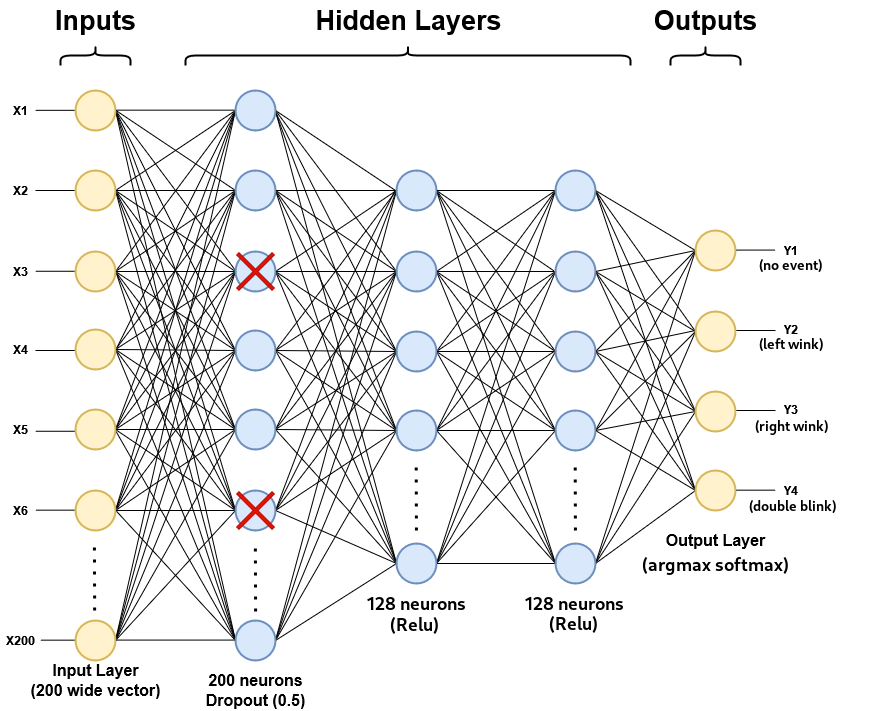

#### Figure 5: Final Model (above)
We select the above ANN as our final model thanks to its relatively competitive accuracy (\~95%), and its superior FDR (\~0.20). Ultimately, we decided that unintential inputs are completely detrimental to keyboard usage, and so the model which tends to falsely discover inputs at a significantly lower rate was selected. This is because we found empirically in live experiments that having the keyboard randomly type within intention can be even more frustrating than occasionally typing the wrong character.

### 4.2 Part B

#### 4.2.1 Deployment Process 

To deploy the product, the first step is training an ANN model on **all** wave files. The model is then saved and loaded into the pygame application at launch. Once the user has all electrodes connected, the keyboard should automatically begin detecting user inputs and classifying them into actions via the newly trained model. These actions are then sent directly to UI to control the keyboard.

#### 4.2.2 Description of Keyboard

The [final keyboard](#Appendix-Figure-2:-New-keyboard-design-(visual-cues-+-colour)) is presented as a 5-layer binary tree with the keys located at the bottom layer and the other nodes left as blanks. This allows users to interact with the keyboard using a minimum number of actions. Specifically, the cursor can be shifted to its left child by a left wink, or to its right child by a right wink. Once a leaf node is reached, double blinks will either type a character or word, or performs certain modifications on the input (e.g. backspace, newline, space). Also, left or right winks on a leaf node will bring the cursor back to the root without typing the currently selected letter.

The keyboard also supports the functionality of navigating up to a parent node by double blinking on the nodes other than the root and leaf nodes. This allows users to traverse back up the tree when a wink is made unintentionally by the user or mistakenly detected by the model.

Lastly, selecting the root node enables the switching between the different modes of the keyboard: lowercase alphabets, uppercase alphabets, punctuations and autocomplete.

## 5. Discussion and Conclusion

### 5.1. Issues Addressed

#### 5.1.1 Issues Addressed in the Development Process

During the initial data collection phase, instructions and timestamps were manually recorded by one team member while another, attached to the SpikerBox, would execute the action. In addition to being inefficient, this process often resulted in misalignment between event timestamps and signal spikes. By developing a UI ([see appendix](#Appendix-Figure-3:-Data-Collection-Mechanism)) which integrated and automated instruction read-outs, event logging and simulation of random eye motion, this process was significantly streamlined and the dependency on a second team member removed, allowing more training data to be collected per session. With future implementations, packaging the data collection UI with the virtual keyboard will enable new users to fine tune pre-trained models for better generalisation.


Additionally, the design for the keyboard went through multiple iterations. Initially, a wheel type design was chosen, in order to cycle through all letters with a small amount of inputs. The downside of this design was that the user would have to navigate through more than 13 letters (half of the alphabet + additional punctuation etc) at worst. So a binary tree keyboard layout was chosen with the understanding of it having the shortest navigation times to improve usability of the product. 


It was originally planned to use left and right eye movements for the project. However, this introduced the issue of unintentional movements of the eye being registered as inputs. To counter this, a protocol was suggested of adding double blinks before a horizontal eye movement to ensure the action was intentional.Unsurprisingly, this introduced a worsened user experience due to eye fatigue from the repeated blinking. In the end, winks were chosen as a superior input method.


#### 5.1.2 Limitations

Factors such as electrode placement, ambient luminosity, muscle contraction strength and electrode-skin contact can introduce some level of variability in the EOG waveforms amongst users. For example, depending on electrode placement relative to the source generator (eye), signal amplitudes for left and right winks were observed to vary in magnitude. The complexities in the signals arising from these contributions is expected to have a detrimental effect on the generalisation of the trained model to new-users. However in future implementations, model performance can be improved through larger training sets acquired from hundreds (or thousands) of users in order to capture the full range of potential operating environments, electrode placements and other user-to-user variability.

### 5.2. Future Work

#### 5.2.1. EOG Hardware

Avenues for EOG hardware improvement are:
  
  1) Additional electrodes in the vertical orientation allow for more degrees of freedom in user input.
  
  2) Integration of professional grade EOG hardware. The SpikerBox, is “appropriate for use in middle/high school educational programs and by amateurs” (Marzullo & Gage, 2012).
  
These changes would impact the performance by providing better signals to the classifier, thus creating room for improved input-classification.


### 5.3. Conclusion

The team set-out to develop a virtual-keyboard which could be used by patients suffering from Motor Neuron Diseases, and created a high-fidelity prototype. 

To achieve this, interdisciplinary effectiveness was crucial. The data collected by Physics students was the foundation upon which Data-Science students built classification models, which made the virtual keyboard usable.  
Based on the Human-Centered evaluation strategy, the ANN was used in our final prototype, due to its remarkable performance in all three sub-segments of the evaluation strategy. 

In the future, after the integration/development of the haptic-communicator, better classifiers, professional EOG-hardware and portability-modules, the product will be ready for use not only by MND patients, but anyone who requires hands-free typing. 


## 6. Student Contribution

### 6.1 Matty

My contributions were focused in the Data Science and Computer Science disciplines. Within the product, I worked mainly on the data preprocessing and data classification stages. This involved preparing the data in a form ready for ML, and building the ANN and SVM models. I also worked on the UI, in particular building a data collection interface that allowed for more efficient collection of training data for the models. In the report, I worked mainly on the data aspects of methods and results (Part A), with some contributions to other data-related sections.

### 6.2 Ashwin

As a Data Science and Computer Science disciple, my contributions were:
   
   a) Development of classification models;
   
   b) Qualitative, quantitative and graphical evaluation of models;
   
   c) Development and integration of Haptic Module;
   
   d) Evaluation of keyboard layout;
   
   e) Conducting a literature review on key-board layouts;
   
   f) Writing the report sections relating to classification and evaluation methods.
   
   g) Presentation slides for product introduction 
   
I also helped during the data collection process.
I would like to acknowledge the constant support and feedback the teammates provided me with. 

### 6.3 Marcus

Focused on initial data analysis using R, report writing (part of methods, aims, plus editing report overall) , presentation production (spoke on user experience and conclusion in presentation), discussing and brainstorming as well as script writing. Also used to collect training data for the product. 

### 6.4. Alex

Using my physics background, I contributed to initial product development and brainstorming the implementation of keyboard designs as well as participating in multiple data collection sessions. Within them, I worked with Josh to ensure the data collected for the classifier was as high quality as possible, incorporating random movements of the eye and experimenting with different electrode placements, spiker boxes, and members of the group. Finally, I edited and presented the slides on data collection, as well as collaborated on the report focusing mainly on the physics background and discussion components.

### 6.5. Jingyu

As a data student with coding experience, I contributed in:
- Idea generation and prototype creation of the binary tree keyboard layout;
- Implementation of Pygame-based user interface;
- Improvement of UI features and functionalities in the evaluation phase;
- Integrating classification model and UI
- Participation in presentation and report writing.


### 6.9. Josh


As a physics student my primary role in the project involved working directly with the SpikerBox to determine optimal electrode placement and writing code to stream raw data in both MATLAB and python. Furthermore, I tested a range of digital filters and experimented with fine-tuning filter parameters. I participated in data collection by instructing actions based on pre-determined sequences as well as performing the actions myself. In the presentation, I contributed to slide design and provided a live demonstration of the virtual keyboard. Additionally, I contributed to writing and editing the background and discussion sections in the final report as well as the ANN, confusion matrix and data flow diagrams. 

## 7. References

1) What is ALS/MND?. (2022). Retrieved 8 May 2022, from https://www.als-mnd.org/what-is-alsmnd/#:~:text=Although%20classified%20as%20a%20rare,384%20new%20cases%20every%20day!

2) Bulling, Andreas; Ward, Jamie A.; Gellersen, Hans; Tröster, Gerhard (2009). [ACM Press the 11th international conference - Orlando, Florida, USA (2009.09.30-2009.10.03)] Proceedings of the 11th international conference on Ubiquitous computing - Ubicomp '09 - Eye movement analysis for activity recognition. , (), 41–. doi:10.1145/1620545.1620552 

3) Japkowicz, N., & Shah, M. (2011). Evaluating Learning Algorithms:A Classification Perspective. Retrieved 27 May 2022, from https://dl.acm.org/doi/10.5555/1964882

4) Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. Retrieved 28 May 2022, from https://dl.acm.org/doi/pdf/10.1145/2939672.2939785 

5) Marzullo, T., & Gage, G. (2012). The SpikerBox: A Low Cost, Open-Source BioAmplifier for Increasing Public Participation in Neuroscience Inquiry. Retrieved 29 May 2022, from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3310049/ 

6) Guenther, N. and Schonlau, M., 2016. Support Vector Machines. [online] SAGE journals. Available at: <https://journals.sagepub.com/doi/10.1177/1536867X1601600407> [Accessed 28 May 2022].

7) Breiman, L., & Cutler, A. (2006). Random forests - copyright. Retrieved 28 May 2022, from https://www.stat.berkeley.edu/~breiman/RandomForests/cc_copyright.htm


## 8. Appendix

#### EXAMPLE Figure 2: Hyperparameter Analysis
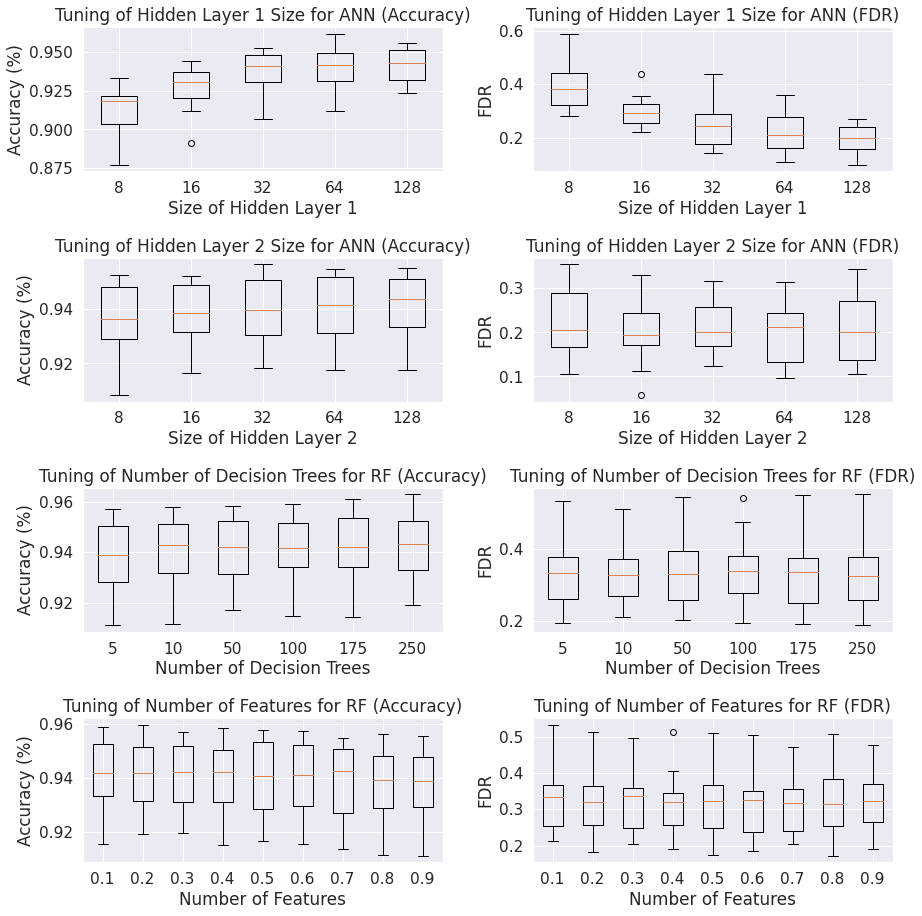

#### EXAMPLE Figure 3: Model Comparison
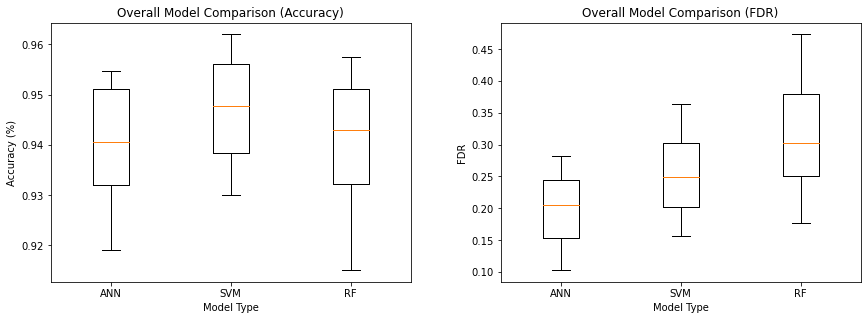

#### EXAMPLE Figure 4: Model Quantitative Comparison
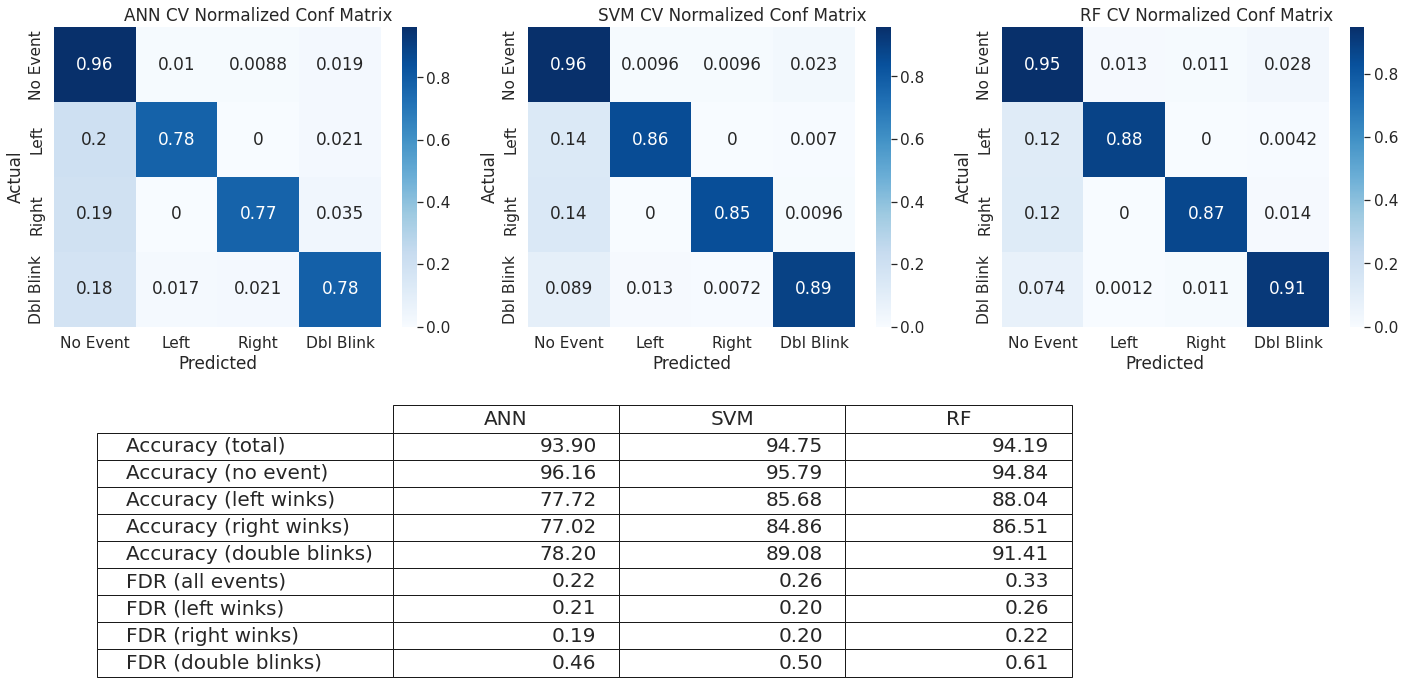

#### Appendix Figure 1: Old keyboard design (no colours / visual cues)
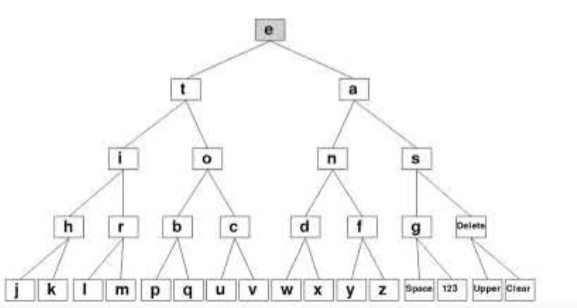

#### Appendix Figure 2: New keyboard design (visual cues + colour)
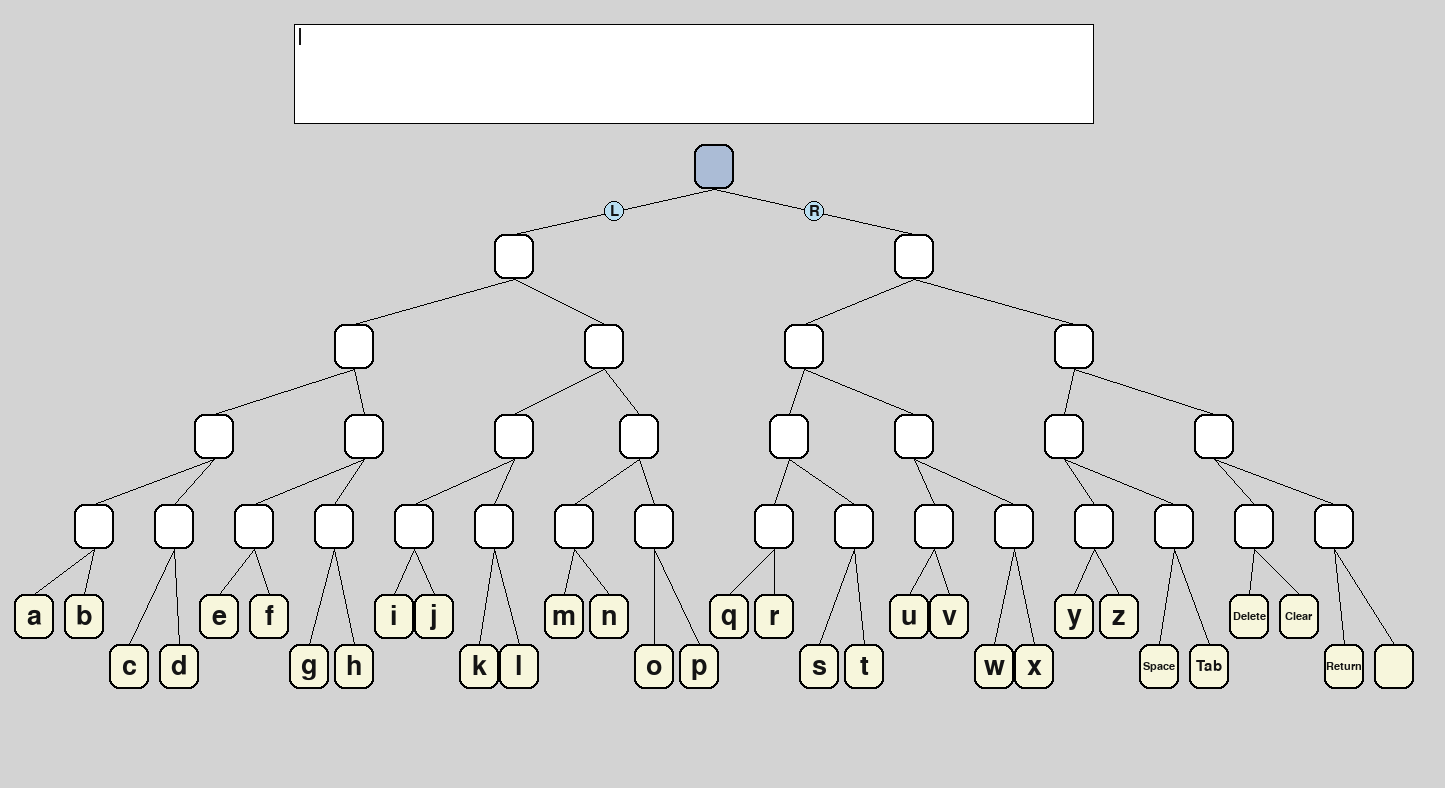

#### Appendix Figure 3: Data Collection Mechanism
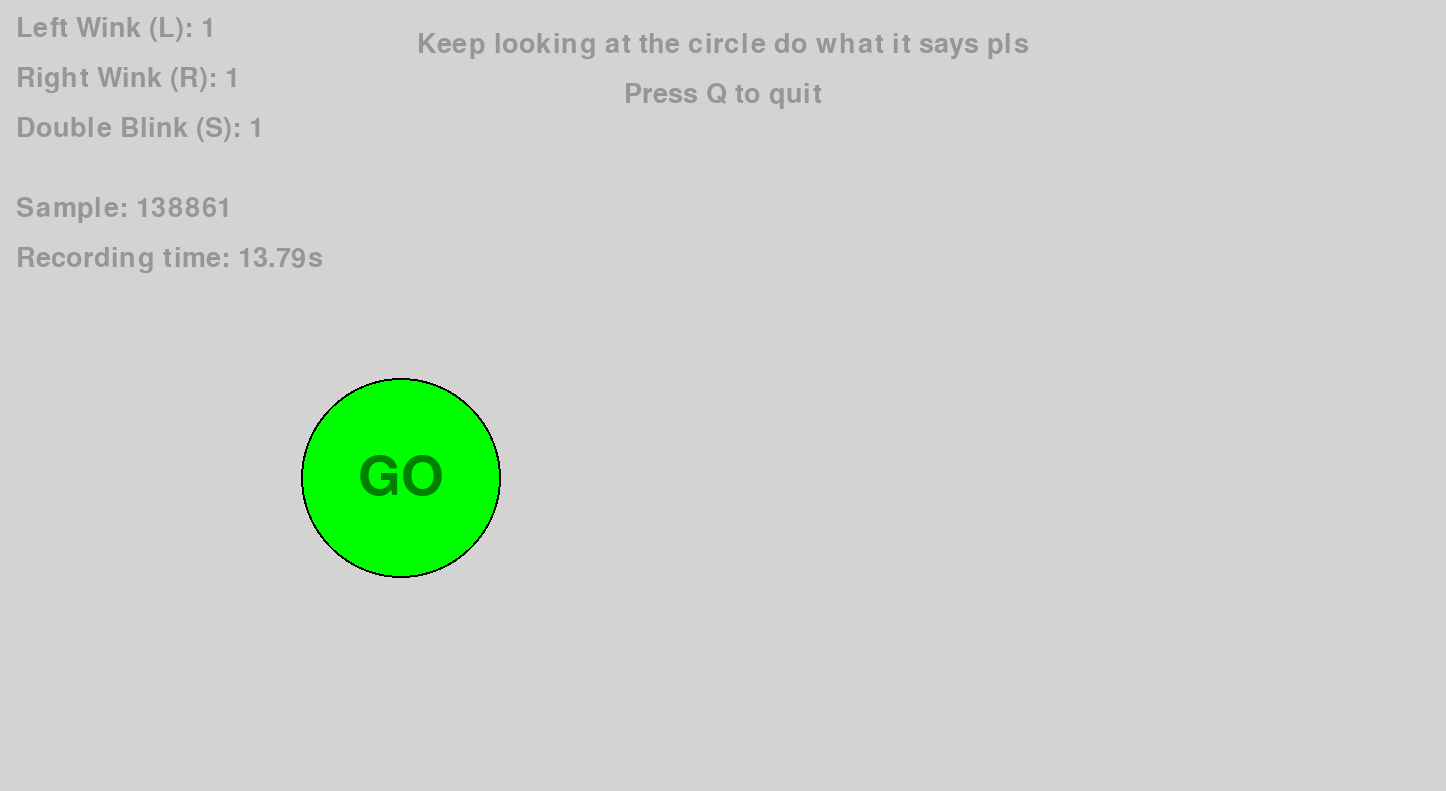